#1. Setup


In [ ]:
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

from torchsummary import summary

import matplotlib.pyplot as plt
import cv2

import time
import os

from PIL import Image

from tqdm import tqdm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread, imsave
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage


torch.manual_seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#2. Data Setup

In [ ]:
cd /content/drive/MyDrive/data/

/content/drive/MyDrive/data


In [ ]:
!unzip '/content/drive/My Drive/data/cropped dogs.zip' -d '/root/datasets'

Archive:  /content/drive/My Drive/data/cropped dogs.zip
   creating: /root/datasets/cropped dogs/.ipynb_checkpoints/
   creating: /root/datasets/cropped dogs/Chihuahua/.ipynb_checkpoints/
   creating: /root/datasets/cropped dogs/Beagle/.ipynb_checkpoints/
  inflating: /root/datasets/cropped dogs/Chihuahua/n02085620_3006.jpg  
   creating: /root/datasets/cropped dogs/Shiba Inu/.ipynb_checkpoints/
  inflating: /root/datasets/cropped dogs/Chihuahua/flipped_n02085620_1152.jpg  
  inflating: /root/datasets/cropped dogs/Chihuahua/flipped_n02085620_7.jpg  
  inflating: /root/datasets/cropped dogs/Chihuahua/flipped_n02085620_1271.jpg  
  inflating: /root/datasets/cropped dogs/Chihuahua/flipped_n02085620_1569.jpg  
  inflating: /root/datasets/cropped dogs/Chihuahua/flipped_n02085620_1492.jpg  
  inflating: /root/datasets/cropped dogs/Chihuahua/n02085620_1492.jpg  
  inflating: /root/datasets/cropped dogs/Chihuahua/n02085620_1620.jpg  
  inflating: /root/datasets/cropped dogs/Chihuahua/n02085620

In [ ]:
# define training and test data directories
main_dir = '/root/datasets/cropped dogs'
split_data_dir = '/root/split_dataset'

classes = ['Beagle', 'Chihuahua', 'French Bulldog', 'German Shepherd', 'Golden Retriever', 'Labrador Retriever', 'Poodle', 'Samoyed', 'Schnauzer', 'Shiba Inu', 'West Highland White Terrier']

In [ ]:
import splitfolders

splitfolders.ratio(main_dir, output=split_data_dir, seed=1337, ratio=(.6, 0.2 , 0.2))


train_dir = os.path.join(split_data_dir, 'train')
val_dir = os.path.join(split_data_dir, 'val')
test_dir = os.path.join(split_data_dir, 'test')

Copying files: 3132 files [00:01, 3064.32 files/s]


In [ ]:
print(os.path.exists(split_data_dir + '/test/.ipynb_checkpoints'))
os.rmdir(split_data_dir + '/test/.ipynb_checkpoints')
print(os.listdir(split_data_dir + '/test'))

print(os.path.exists(split_data_dir + '/train/.ipynb_checkpoints'))
os.rmdir(split_data_dir + '/train/.ipynb_checkpoints')
print(os.listdir(split_data_dir + '/train'))

print(os.path.exists(split_data_dir + '/val/.ipynb_checkpoints'))
os.rmdir(split_data_dir + '/val/.ipynb_checkpoints')
print(os.listdir(split_data_dir + '/val'))


True
['Samoyed', 'Labrador Retriever', 'Beagle', 'Chihuahua', 'Schnauzer', 'Shiba Inu', 'Golden Retriever', 'West Highland White Terrier', 'German Shepherd', 'Poodle', 'French Bulldog']
True
['Samoyed', 'Labrador Retriever', 'Beagle', 'Chihuahua', 'Schnauzer', 'Shiba Inu', 'Golden Retriever', 'West Highland White Terrier', 'German Shepherd', 'Poodle', 'French Bulldog']
True
['Samoyed', 'Labrador Retriever', 'Beagle', 'Chihuahua', 'Schnauzer', 'Shiba Inu', 'Golden Retriever', 'West Highland White Terrier', 'German Shepherd', 'Poodle', 'French Bulldog']


In [ ]:
# load and transform data using ImageFolder

# resize all images to 256 x 256, crop to 224 x 224, transform to tensor, normalize
data_transform = transforms.Compose([transforms.Resize(256)                    
                                     ,transforms.CenterCrop(224)                #[3]
                                     ,transforms.ToTensor()                     #[4]
                                     ,transforms.Normalize(                      #[5]
                                     mean=[0.485, 0.456, 0.406],                #[6]
                                     std=[0.229, 0.224, 0.225]                  #[7]
                                     )
                                    ])
                                   
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Number of training images: ', len(train_data))
print('Number of validation images: ', len(val_data))
print('Number of test images: ', len(test_data))

Number of training images:  1876
Number of validation images:  624
Number of test images:  632


In [ ]:
# define dataloader parameters
batch_size = 32
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

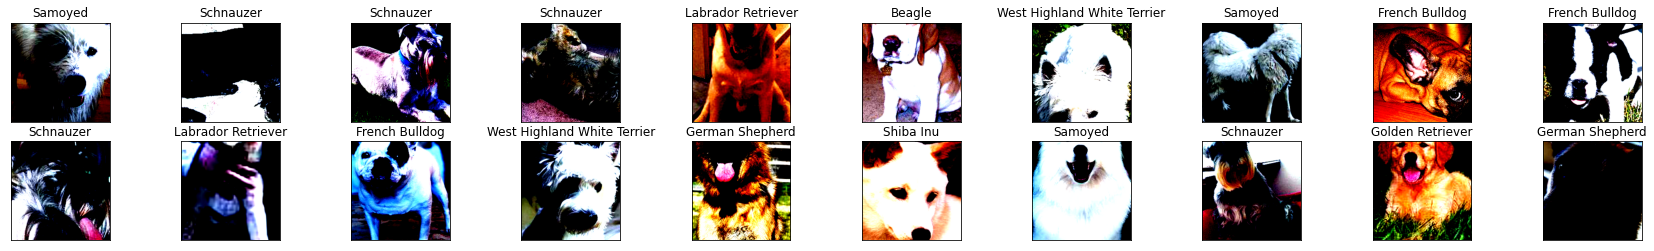

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(30, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

#3. Transfer Learning

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features

#4. Classification Model

In [ ]:
 class AlexClassifier(nn.Module):
    def __init__(self):
        super(AlexClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6,  4069)
        self.fc2 = nn.Linear(4069,  1000)
        self.fc3 = nn.Linear(1000, 11)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Copyright (c) 2019, Adobe Inc. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike
# 4.0 International Public License. To view a copy of this license, visit
# https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode.

"""
自定义pytorch函数，实现一维、二维、三维张量的DWT和IDWT，未考虑边界延拓
只有当图像行列数都是偶数，且重构滤波器组低频分量长度为2时，才能精确重构，否则在边界处有误差。
"""
import torch
from torch.autograd import Function

class DWTFunction_1D(Function):
    @staticmethod
    def forward(ctx, input, matrix_Low, matrix_High):
        ctx.save_for_backward(matrix_Low, matrix_High)
        L = torch.matmul(input, matrix_Low.t())
        H = torch.matmul(input, matrix_High.t())
        return L, H
    @staticmethod
    def backward(ctx, grad_L, grad_H):
        matrix_L, matrix_H = ctx.saved_variables
        grad_input = torch.add(torch.matmul(grad_L, matrix_L), torch.matmul(grad_H, matrix_H))
        return grad_input, None, None


class IDWTFunction_1D(Function):
    @staticmethod
    def forward(ctx, input_L, input_H, matrix_L, matrix_H):
        ctx.save_for_backward(matrix_L, matrix_H)
        output = torch.add(torch.matmul(input_L, matrix_L), torch.matmul(input_H, matrix_H))
        return output
    @staticmethod
    def backward(ctx, grad_output):
        matrix_L, matrix_H = ctx.saved_variables
        grad_L = torch.matmul(grad_output, matrix_L.t())
        grad_H = torch.matmul(grad_output, matrix_H.t())
        return grad_L, grad_H, None, None


class DWTFunction_2D(Function):
    @staticmethod
    def forward(ctx, input, matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1):
        ctx.save_for_backward(matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1)
        L = torch.matmul(matrix_Low_0, input)
        H = torch.matmul(matrix_High_0, input)
        LL = torch.matmul(L, matrix_Low_1)
        LH = torch.matmul(L, matrix_High_1)
        HL = torch.matmul(H, matrix_Low_1)
        HH = torch.matmul(H, matrix_High_1)
        return LL, LH, HL, HH
    @staticmethod
    def backward(ctx, grad_LL, grad_LH, grad_HL, grad_HH):
        matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1 = ctx.saved_variables
        grad_L = torch.add(torch.matmul(grad_LL, matrix_Low_1.t()), torch.matmul(grad_LH, matrix_High_1.t()))
        grad_H = torch.add(torch.matmul(grad_HL, matrix_Low_1.t()), torch.matmul(grad_HH, matrix_High_1.t()))
        grad_input = torch.add(torch.matmul(matrix_Low_0.t(), grad_L), torch.matmul(matrix_High_0.t(), grad_H))
        return grad_input, None, None, None, None


class DWTFunction_2D_tiny(Function):
    @staticmethod
    def forward(ctx, input, matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1):
        ctx.save_for_backward(matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1)
        L = torch.matmul(matrix_Low_0, input)
        LL = torch.matmul(L, matrix_Low_1)
        return LL
    @staticmethod
    def backward(ctx, grad_LL):
        matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1 = ctx.saved_variables
        grad_L = torch.matmul(grad_LL, matrix_Low_1.t())
        grad_input = torch.matmul(matrix_Low_0.t(), grad_L)
        return grad_input, None, None, None, None


class IDWTFunction_2D(Function):
    @staticmethod
    def forward(ctx, input_LL, input_LH, input_HL, input_HH,
                matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1):
        ctx.save_for_backward(matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1)
        L = torch.add(torch.matmul(input_LL, matrix_Low_1.t()), torch.matmul(input_LH, matrix_High_1.t()))
        H = torch.add(torch.matmul(input_HL, matrix_Low_1.t()), torch.matmul(input_HH, matrix_High_1.t()))
        output = torch.add(torch.matmul(matrix_Low_0.t(), L), torch.matmul(matrix_High_0.t(), H))
        return output
    @staticmethod
    def backward(ctx, grad_output):
        matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1 = ctx.saved_variables
        grad_L = torch.matmul(matrix_Low_0, grad_output)
        grad_H = torch.matmul(matrix_High_0, grad_output)
        grad_LL = torch.matmul(grad_L, matrix_Low_1)
        grad_LH = torch.matmul(grad_L, matrix_High_1)
        grad_HL = torch.matmul(grad_H, matrix_Low_1)
        grad_HH = torch.matmul(grad_H, matrix_High_1)
        return grad_LL, grad_LH, grad_HL, grad_HH, None, None, None, None


class DWTFunction_3D(Function):
    @staticmethod
    def forward(ctx, input,
                matrix_Low_0, matrix_Low_1, matrix_Low_2,
                matrix_High_0, matrix_High_1, matrix_High_2):
        ctx.save_for_backward(matrix_Low_0, matrix_Low_1, matrix_Low_2,
                              matrix_High_0, matrix_High_1, matrix_High_2)
        L = torch.matmul(matrix_Low_0, input)
        H = torch.matmul(matrix_High_0, input)
        LL = torch.matmul(L, matrix_Low_1).transpose(dim0 = 2, dim1 = 3)
        LH = torch.matmul(L, matrix_High_1).transpose(dim0 = 2, dim1 = 3)
        HL = torch.matmul(H, matrix_Low_1).transpose(dim0 = 2, dim1 = 3)
        HH = torch.matmul(H, matrix_High_1).transpose(dim0 = 2, dim1 = 3)
        LLL = torch.matmul(matrix_Low_2, LL).transpose(dim0 = 2, dim1 = 3)
        LLH = torch.matmul(matrix_Low_2, LH).transpose(dim0 = 2, dim1 = 3)
        LHL = torch.matmul(matrix_Low_2, HL).transpose(dim0 = 2, dim1 = 3)
        LHH = torch.matmul(matrix_Low_2, HH).transpose(dim0 = 2, dim1 = 3)
        HLL = torch.matmul(matrix_High_2, LL).transpose(dim0 = 2, dim1 = 3)
        HLH = torch.matmul(matrix_High_2, LH).transpose(dim0 = 2, dim1 = 3)
        HHL = torch.matmul(matrix_High_2, HL).transpose(dim0 = 2, dim1 = 3)
        HHH = torch.matmul(matrix_High_2, HH).transpose(dim0 = 2, dim1 = 3)
        return LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH

    @staticmethod
    def backward(ctx, grad_LLL, grad_LLH, grad_LHL, grad_LHH,
                      grad_HLL, grad_HLH, grad_HHL, grad_HHH):
        matrix_Low_0, matrix_Low_1, matrix_Low_2, matrix_High_0, matrix_High_1, matrix_High_2 = ctx.saved_variables
        grad_LL = torch.add(torch.matmul(matrix_Low_2.t(), grad_LLL.transpose(dim0 = 2, dim1 = 3)), torch.matmul(matrix_High_2.t(), grad_HLL.transpose(dim0 = 2, dim1 = 3))).transpose(dim0 = 2, dim1 = 3)
        grad_LH = torch.add(torch.matmul(matrix_Low_2.t(), grad_LLH.transpose(dim0 = 2, dim1 = 3)), torch.matmul(matrix_High_2.t(), grad_HLH.transpose(dim0 = 2, dim1 = 3))).transpose(dim0 = 2, dim1 = 3)
        grad_HL = torch.add(torch.matmul(matrix_Low_2.t(), grad_LHL.transpose(dim0 = 2, dim1 = 3)), torch.matmul(matrix_High_2.t(), grad_HHL.transpose(dim0 = 2, dim1 = 3))).transpose(dim0 = 2, dim1 = 3)
        grad_HH = torch.add(torch.matmul(matrix_Low_2.t(), grad_LHH.transpose(dim0 = 2, dim1 = 3)), torch.matmul(matrix_High_2.t(), grad_HHH.transpose(dim0 = 2, dim1 = 3))).transpose(dim0 = 2, dim1 = 3)
        grad_L = torch.add(torch.matmul(grad_LL, matrix_Low_1.t()), torch.matmul(grad_LH, matrix_High_1.t()))
        grad_H = torch.add(torch.matmul(grad_HL, matrix_Low_1.t()), torch.matmul(grad_HH, matrix_High_1.t()))
        grad_input = torch.add(torch.matmul(matrix_Low_0.t(), grad_L), torch.matmul(matrix_High_0.t(), grad_H))
        return grad_input, None, None, None, None, None, None, None, None


class IDWTFunction_3D(Function):
    @staticmethod
    def forward(ctx, input_LLL, input_LLH, input_LHL, input_LHH,
                     input_HLL, input_HLH, input_HHL, input_HHH,
                     matrix_Low_0, matrix_Low_1, matrix_Low_2,
                     matrix_High_0, matrix_High_1, matrix_High_2):
        ctx.save_for_backward(matrix_Low_0, matrix_Low_1, matrix_Low_2,
                              matrix_High_0, matrix_High_1, matrix_High_2)
        input_LL = torch.add(torch.matmul(matrix_Low_2.t(), input_LLL.transpose(dim0 = 2, dim1 = 3)), torch.matmul(matrix_High_2.t(), input_HLL.transpose(dim0 = 2, dim1 = 3))).transpose(dim0 = 2, dim1 = 3)
        input_LH = torch.add(torch.matmul(matrix_Low_2.t(), input_LLH.transpose(dim0 = 2, dim1 = 3)), torch.matmul(matrix_High_2.t(), input_HLH.transpose(dim0 = 2, dim1 = 3))).transpose(dim0 = 2, dim1 = 3)
        input_HL = torch.add(torch.matmul(matrix_Low_2.t(), input_LHL.transpose(dim0 = 2, dim1 = 3)), torch.matmul(matrix_High_2.t(), input_HHL.transpose(dim0 = 2, dim1 = 3))).transpose(dim0 = 2, dim1 = 3)
        input_HH = torch.add(torch.matmul(matrix_Low_2.t(), input_LHH.transpose(dim0 = 2, dim1 = 3)), torch.matmul(matrix_High_2.t(), input_HHH.transpose(dim0 = 2, dim1 = 3))).transpose(dim0 = 2, dim1 = 3)
        input_L = torch.add(torch.matmul(input_LL, matrix_Low_1.t()), torch.matmul(input_LH, matrix_High_1.t()))
        input_H = torch.add(torch.matmul(input_HL, matrix_Low_1.t()), torch.matmul(input_HH, matrix_High_1.t()))
        output = torch.add(torch.matmul(matrix_Low_0.t(), input_L), torch.matmul(matrix_High_0.t(), input_H))
        return output
    @staticmethod
    def backward(ctx, grad_output):
        matrix_Low_0, matrix_Low_1, matrix_Low_2, matrix_High_0, matrix_High_1, matrix_High_2 = ctx.saved_variables
        grad_L = torch.matmul(matrix_Low_0, grad_output)
        grad_H = torch.matmul(matrix_High_0, grad_output)
        grad_LL = torch.matmul(grad_L, matrix_Low_1).transpose(dim0 = 2, dim1 = 3)
        grad_LH = torch.matmul(grad_L, matrix_High_1).transpose(dim0 = 2, dim1 = 3)
        grad_HL = torch.matmul(grad_H, matrix_Low_1).transpose(dim0 = 2, dim1 = 3)
        grad_HH = torch.matmul(grad_H, matrix_High_1).transpose(dim0 = 2, dim1 = 3)
        grad_LLL = torch.matmul(matrix_Low_2, grad_LL).transpose(dim0 = 2, dim1 = 3)
        grad_LLH = torch.matmul(matrix_Low_2, grad_LH).transpose(dim0 = 2, dim1 = 3)
        grad_LHL = torch.matmul(matrix_Low_2, grad_HL).transpose(dim0 = 2, dim1 = 3)
        grad_LHH = torch.matmul(matrix_Low_2, grad_HH).transpose(dim0 = 2, dim1 = 3)
        grad_HLL = torch.matmul(matrix_High_2, grad_LL).transpose(dim0 = 2, dim1 = 3)
        grad_HLH = torch.matmul(matrix_High_2, grad_LH).transpose(dim0 = 2, dim1 = 3)
        grad_HHL = torch.matmul(matrix_High_2, grad_HL).transpose(dim0 = 2, dim1 = 3)
        grad_HHH = torch.matmul(matrix_High_2, grad_HH).transpose(dim0 = 2, dim1 = 3)
        return grad_LLL, grad_LLH, grad_LHL, grad_LHH, grad_HLL, grad_HLH, grad_HHL, grad_HHH, None, None, None, None, None, None


In [ ]:
"""
自定义 pytorch 层，实现一维、二维、三维张量的 DWT 和 IDWT，未考虑边界延拓
只有当图像行列数都是偶数，且重构滤波器组低频分量长度为 2 时，才能精确重构，否则在边界处有误差。
"""
import numpy as np
import math
from torch.nn import Module
import pywt

__all__ = ['DWT_1D', 'IDWT_1D', 'DWT_2D', 'IDWT_2D', 'DWT_3D', 'IDWT_3D', 'DWT_2D_tiny']
class DWT_1D(Module):
    """
    input: the 1D data to be decomposed -- (N, C, Length)
    output: lfc -- (N, C, Length/2)
            hfc -- (N, C, Length/2)
    """
    def __init__(self, wavename):
        """
        1D discrete wavelet transform (DWT) for sequence decomposition
        用于序列分解的一维离散小波变换 DWT
        :param wavename: pywt.wavelist(); in the paper, 'chx.y' denotes 'biorx.y'.
        """
        super(DWT_1D, self).__init__()
        wavelet = pywt.Wavelet(wavename)
        self.band_low = wavelet.rec_lo
        self.band_high = wavelet.rec_hi
        assert len(self.band_low) == len(self.band_high)
        self.band_length = len(self.band_low)
        assert self.band_length % 2 == 0
        self.band_length_half = math.floor(self.band_length / 2)

    def get_matrix(self):
        """
        生成变换矩阵
        generating the matrices: \mathcal{L}, \mathcal{H}
        :return: self.matrix_low = \mathcal{L}, self.matrix_high = \mathcal{H}
        """
        L1 = self.input_height
        L = math.floor(L1 / 2)
        matrix_h = np.zeros( ( L,      L1 + self.band_length - 2 ) )
        matrix_g = np.zeros( ( L1 - L, L1 + self.band_length - 2 ) )
        end = None if self.band_length_half == 1 else (-self.band_length_half+1)
        index = 0

        for i in range(L):
            for j in range(self.band_length):
                matrix_h[i, index+j] = self.band_low[j]
            index += 2
        index = 0
        print(matrix_h)
        for i in range(L1 - L):
            for j in range(self.band_length):
                matrix_g[i, index+j] = self.band_high[j]
            index += 2
        matrix_h = matrix_h[:,(self.band_length_half-1):end]
        matrix_g = matrix_g[:,(self.band_length_half-1):end]
        if torch.cuda.is_available():
            self.matrix_low = torch.Tensor(matrix_h).cuda()
            self.matrix_high = torch.Tensor(matrix_g).cuda()
        else:
            self.matrix_low = torch.Tensor(matrix_h)
            self.matrix_high = torch.Tensor(matrix_g)

    def forward(self, input):
        """
        input_low_frequency_component = \mathcal{L} * input
        input_high_frequency_component = \mathcal{H} * input
        :param input: the data to be decomposed
        :return: the low-frequency and high-frequency components of the input data
        """
        assert len(input.size()) == 3
        self.input_height = input.size()[-1]
        self.get_matrix()
        return DWTFunction_1D.apply(input, self.matrix_low, self.matrix_high)


class IDWT_1D(Module):
    """
    input:  lfc -- (N, C, Length/2)
            hfc -- (N, C, Length/2)
    output: the original data -- (N, C, Length)
    """
    def __init__(self, wavename):
        """
        1D inverse DWT (IDWT) for sequence reconstruction
        用于序列重构的一维离散小波逆变换 IDWT
        :param wavename: pywt.wavelist(); in the paper, 'chx.y' denotes 'biorx.y'.
        """
        super(IDWT_1D, self).__init__()
        wavelet = pywt.Wavelet(wavename)
        self.band_low = wavelet.dec_lo
        self.band_high = wavelet.dec_hi
        self.band_low.reverse()
        self.band_high.reverse()
        assert len(self.band_low) == len(self.band_high)
        self.band_length = len(self.band_low)
        assert self.band_length % 2 == 0
        self.band_length_half = math.floor(self.band_length / 2)

    def get_matrix(self):
        """
        generating the matrices: \mathcal{L}, \mathcal{H}
        生成变换矩阵
        :return: self.matrix_low = \mathcal{L}, self.matrix_high = \mathcal{H}
        """
        L1 = self.input_height
        L = math.floor(L1 / 2)
        matrix_h = np.zeros( ( L,      L1 + self.band_length - 2 ) )
        matrix_g = np.zeros( ( L1 - L, L1 + self.band_length - 2 ) )
        end = None if self.band_length_half == 1 else (-self.band_length_half+1)
        index = 0
        for i in range(L):
            for j in range(self.band_length):
                matrix_h[i, index+j] = self.band_low[j]
            index += 2
        index = 0
        for i in range(L1 - L):
            for j in range(self.band_length):
                matrix_g[i, index+j] = self.band_high[j]
            index += 2
        matrix_h = matrix_h[:,(self.band_length_half-1):end]
        matrix_g = matrix_g[:,(self.band_length_half-1):end]
        if torch.cuda.is_available():
            self.matrix_low = torch.Tensor(matrix_h).cuda()
            self.matrix_high = torch.Tensor(matrix_g).cuda()
        else:
            self.matrix_low = torch.Tensor(matrix_h)
            self.matrix_high = torch.Tensor(matrix_g)

    def forward(self, L, H):
        """
        :param L: the low-frequency component of the original data
        :param H: the high-frequency component of the original data
        :return: the original data
        """
        assert len(L.size()) == len(H.size()) == 3
        self.input_height = L.size()[-1] + H.size()[-1]
        self.get_matrix()
        return IDWTFunction_1D.apply(L, H, self.matrix_low, self.matrix_high)


class DWT_2D_tiny(Module):
    """
    input: the 2D data to be decomposed -- (N, C, H, W)
    output -- lfc: (N, C, H/2, W/2)
              #hfc_lh: (N, C, H/2, W/2)
              #hfc_hl: (N, C, H/2, W/2)
              #hfc_hh: (N, C, H/2, W/2)
    DWT_2D_tiny only outputs the low-frequency component, which is used in WaveCNet;
    the all four components could be get using DWT_2D, which is used in WaveUNet.
    """
    def __init__(self, wavename):
        """
        2D discrete wavelet transform (DWT) for 2D image decomposition
        :param wavename: pywt.wavelist(); in the paper, 'chx.y' denotes 'biorx.y'.
        """
        super(DWT_2D_tiny, self).__init__()
        wavelet = pywt.Wavelet(wavename)
        self.band_low = wavelet.rec_lo
        self.band_high = wavelet.rec_hi
        assert len(self.band_low) == len(self.band_high)
        self.band_length = len(self.band_low)
        assert self.band_length % 2 == 0
        self.band_length_half = math.floor(self.band_length / 2)

    def get_matrix(self):
        """
        生成变换矩阵
        generating the matrices: \mathcal{L}, \mathcal{H}
        :return: self.matrix_low = \mathcal{L}, self.matrix_high = \mathcal{H}
        """
        L1 = np.max((self.input_height, self.input_width))
        L = math.floor(L1 / 2)
        matrix_h = np.zeros( ( L,      L1 + self.band_length - 2 ) )
        matrix_g = np.zeros( ( L1 - L, L1 + self.band_length - 2 ) )
        end = None if self.band_length_half == 1 else (-self.band_length_half+1)

        index = 0
        # print("size h = " + str(matrix_g.shape))
        # print("size g = " + str(matrix_g.shape))
        for i in range(L):
            for j in range(self.band_length):
                # print("i " + str(i))
                # print(" index + j = " + str(index + j))
                matrix_h[i, index+j] = self.band_low[j]
            index += 2
        matrix_h_0 = matrix_h[0:(math.floor(self.input_height / 2)), 0:(self.input_height + self.band_length - 2)]
        matrix_h_1 = matrix_h[0:(math.floor(self.input_width / 2)), 0:(self.input_width + self.band_length - 2)]
      
        index = 0
        # for i in range(L1 - L):
        for i in range(L):
            for j in range(self.band_length):
                # print("i " + str(i))
                # print(" index + j = " + str(index + j))
                matrix_g[i, index+j] = self.band_high[j]
            index += 2
        matrix_g_0 = matrix_g[0:(self.input_height - math.floor(self.input_height / 2)),0:(self.input_height + self.band_length - 2)]
        matrix_g_1 = matrix_g[0:(self.input_width - math.floor(self.input_width / 2)),0:(self.input_width + self.band_length - 2)]

        matrix_h_0 = matrix_h_0[:,(self.band_length_half-1):end]
        matrix_h_1 = matrix_h_1[:,(self.band_length_half-1):end]
        matrix_h_1 = np.transpose(matrix_h_1)
        matrix_g_0 = matrix_g_0[:,(self.band_length_half-1):end]
        matrix_g_1 = matrix_g_1[:,(self.band_length_half-1):end]
        matrix_g_1 = np.transpose(matrix_g_1)

        if torch.cuda.is_available():
            self.matrix_low_0 = torch.Tensor(matrix_h_0).cuda()
            self.matrix_low_1 = torch.Tensor(matrix_h_1).cuda()
            self.matrix_high_0 = torch.Tensor(matrix_g_0).cuda()
            self.matrix_high_1 = torch.Tensor(matrix_g_1).cuda()
        else:
            self.matrix_low_0 = torch.Tensor(matrix_h_0)
            self.matrix_low_1 = torch.Tensor(matrix_h_1)
            self.matrix_high_0 = torch.Tensor(matrix_g_0)
            self.matrix_high_1 = torch.Tensor(matrix_g_1)

    def forward(self, input):
        """
        input_lfc = \mathcal{L} * input * \mathcal{L}^T
        #input_hfc_lh = \mathcal{H} * input * \mathcal{L}^T
        #input_hfc_hl = \mathcal{L} * input * \mathcal{H}^T
        #input_hfc_hh = \mathcal{H} * input * \mathcal{H}^T
        :param input: the 2D data to be decomposed
        :return: the low-frequency component of the input 2D data
        """
        assert len(input.size()) == 4
        self.input_height = input.size()[-2]
        self.input_width = input.size()[-1]
        self.get_matrix()
        return DWTFunction_2D_tiny.apply(input, self.matrix_low_0, self.matrix_low_1, self.matrix_high_0, self.matrix_high_1)


class DWT_2D(Module):
    """
    input: the 2D data to be decomposed -- (N, C, H, W)
    output -- lfc: (N, C, H/2, W/2)
              hfc_lh: (N, C, H/2, W/2)
              hfc_hl: (N, C, H/2, W/2)
              hfc_hh: (N, C, H/2, W/2)
    """
    def __init__(self, wavename):
        """
        2D discrete wavelet transform (DWT) for 2D image decomposition
        :param wavename: pywt.wavelist(); in the paper, 'chx.y' denotes 'biorx.y'.
        """
        super(DWT_2D, self).__init__()
        wavelet = pywt.Wavelet(wavename)
        self.band_low = wavelet.rec_lo
        self.band_high = wavelet.rec_hi
        assert len(self.band_low) == len(self.band_high)
        self.band_length = len(self.band_low)
        assert self.band_length % 2 == 0
        self.band_length_half = math.floor(self.band_length / 2)

    def get_matrix(self):
        """
        生成变换矩阵
        generating the matrices: \mathcal{L}, \mathcal{H}
        :return: self.matrix_low = \mathcal{L}, self.matrix_high = \mathcal{H}
        """
        L1 = np.max((self.input_height, self.input_width))
        L = math.floor(L1 / 2)
        matrix_h = np.zeros( ( L,      L1 + self.band_length - 2 ) )
        matrix_g = np.zeros( ( L1 - L, L1 + self.band_length - 2 ) )
        end = None if self.band_length_half == 1 else (-self.band_length_half+1)

        index = 0
        for i in range(L):
            for j in range(self.band_length):
                matrix_h[i, index+j] = self.band_low[j]
            index += 2
        matrix_h_0 = matrix_h[0:(math.floor(self.input_height / 2)), 0:(self.input_height + self.band_length - 2)]
        matrix_h_1 = matrix_h[0:(math.floor(self.input_width / 2)), 0:(self.input_width + self.band_length - 2)]

        index = 0
        for i in range(L1 - L):
            for j in range(self.band_length):
                matrix_g[i, index+j] = self.band_high[j]
            index += 2
        matrix_g_0 = matrix_g[0:(self.input_height - math.floor(self.input_height / 2)),0:(self.input_height + self.band_length - 2)]
        matrix_g_1 = matrix_g[0:(self.input_width - math.floor(self.input_width / 2)),0:(self.input_width + self.band_length - 2)]

        matrix_h_0 = matrix_h_0[:,(self.band_length_half-1):end]
        matrix_h_1 = matrix_h_1[:,(self.band_length_half-1):end]
        matrix_h_1 = np.transpose(matrix_h_1)
        matrix_g_0 = matrix_g_0[:,(self.band_length_half-1):end]
        matrix_g_1 = matrix_g_1[:,(self.band_length_half-1):end]
        matrix_g_1 = np.transpose(matrix_g_1)

        if torch.cuda.is_available():
            self.matrix_low_0 = torch.Tensor(matrix_h_0).cuda()
            self.matrix_low_1 = torch.Tensor(matrix_h_1).cuda()
            self.matrix_high_0 = torch.Tensor(matrix_g_0).cuda()
            self.matrix_high_1 = torch.Tensor(matrix_g_1).cuda()
        else:
            self.matrix_low_0 = torch.Tensor(matrix_h_0)
            self.matrix_low_1 = torch.Tensor(matrix_h_1)
            self.matrix_high_0 = torch.Tensor(matrix_g_0)
            self.matrix_high_1 = torch.Tensor(matrix_g_1)

    def forward(self, input):
        """
        input_lfc = \mathcal{L} * input * \mathcal{L}^T
        input_hfc_lh = \mathcal{H} * input * \mathcal{L}^T
        input_hfc_hl = \mathcal{L} * input * \mathcal{H}^T
        input_hfc_hh = \mathcal{H} * input * \mathcal{H}^T
        :param input: the 2D data to be decomposed
        :return: the low-frequency and high-frequency components of the input 2D data
        """
        assert len(input.size()) == 4
        self.input_height = input.size()[-2]
        self.input_width = input.size()[-1]
        self.get_matrix()
        return DWTFunction_2D.apply(input, self.matrix_low_0, self.matrix_low_1, self.matrix_high_0, self.matrix_high_1)


class IDWT_2D(Module):
    """
    input:  lfc -- (N, C, H/2, W/2)
            hfc_lh -- (N, C, H/2, W/2)
            hfc_hl -- (N, C, H/2, W/2)
            hfc_hh -- (N, C, H/2, W/2)
    output: the original 2D data -- (N, C, H, W)
    """
    def __init__(self, wavename):
        """
        2D inverse DWT (IDWT) for 2D image reconstruction
        :param wavename: pywt.wavelist(); in the paper, 'chx.y' denotes 'biorx.y'.
        """
        super(IDWT_2D, self).__init__()
        wavelet = pywt.Wavelet(wavename)
        self.band_low = wavelet.dec_lo
        self.band_low.reverse()
        self.band_high = wavelet.dec_hi
        self.band_high.reverse()
        assert len(self.band_low) == len(self.band_high)
        self.band_length = len(self.band_low)
        assert self.band_length % 2 == 0
        self.band_length_half = math.floor(self.band_length / 2)

    def get_matrix(self):
        """
        生成变换矩阵
        generating the matrices: \mathcal{L}, \mathcal{H}
        :return: self.matrix_low = \mathcal{L}, self.matrix_high = \mathcal{H}
        """
        L1 = np.max((self.input_height, self.input_width))
        L = math.floor(L1 / 2)
        matrix_h = np.zeros( ( L,      L1 + self.band_length - 2 ) )
        matrix_g = np.zeros( ( L1 - L, L1 + self.band_length - 2 ) )
        end = None if self.band_length_half == 1 else (-self.band_length_half+1)

        index = 0
        for i in range(L):
            for j in range(self.band_length):
                matrix_h[i, index+j] = self.band_low[j]
            index += 2
        matrix_h_0 = matrix_h[0:(math.floor(self.input_height / 2)), 0:(self.input_height + self.band_length - 2)]
        matrix_h_1 = matrix_h[0:(math.floor(self.input_width / 2)), 0:(self.input_width + self.band_length - 2)]

        index = 0
        for i in range(L1 - L):
            for j in range(self.band_length):
                matrix_g[i, index+j] = self.band_high[j]
            index += 2
        matrix_g_0 = matrix_g[0:(self.input_height - math.floor(self.input_height / 2)),0:(self.input_height + self.band_length - 2)]
        matrix_g_1 = matrix_g[0:(self.input_width - math.floor(self.input_width / 2)),0:(self.input_width + self.band_length - 2)]

        matrix_h_0 = matrix_h_0[:,(self.band_length_half-1):end]
        matrix_h_1 = matrix_h_1[:,(self.band_length_half-1):end]
        matrix_h_1 = np.transpose(matrix_h_1)
        matrix_g_0 = matrix_g_0[:,(self.band_length_half-1):end]
        matrix_g_1 = matrix_g_1[:,(self.band_length_half-1):end]
        matrix_g_1 = np.transpose(matrix_g_1)
        if torch.cuda.is_available():
            self.matrix_low_0 = torch.Tensor(matrix_h_0).cuda()
            self.matrix_low_1 = torch.Tensor(matrix_h_1).cuda()
            self.matrix_high_0 = torch.Tensor(matrix_g_0).cuda()
            self.matrix_high_1 = torch.Tensor(matrix_g_1).cuda()
        else:
            self.matrix_low_0 = torch.Tensor(matrix_h_0)
            self.matrix_low_1 = torch.Tensor(matrix_h_1)
            self.matrix_high_0 = torch.Tensor(matrix_g_0)
            self.matrix_high_1 = torch.Tensor(matrix_g_1)

    def forward(self, LL, LH, HL, HH):
        """
        recontructing the original 2D data
        the original 2D data = \mathcal{L}^T * lfc * \mathcal{L}
                             + \mathcal{H}^T * hfc_lh * \mathcal{L}
                             + \mathcal{L}^T * hfc_hl * \mathcal{H}
                             + \mathcal{H}^T * hfc_hh * \mathcal{H}
        :param LL: the low-frequency component
        :param LH: the high-frequency component, hfc_lh
        :param HL: the high-frequency component, hfc_hl
        :param HH: the high-frequency component, hfc_hh
        :return: the original 2D data
        """
        assert len(LL.size()) == len(LH.size()) == len(HL.size()) == len(HH.size()) == 4
        self.input_height = LL.size()[-2] + HH.size()[-2]
        self.input_width = LL.size()[-1] + HH.size()[-1]
        self.get_matrix()
        return IDWTFunction_2D.apply(LL, LH, HL, HH, self.matrix_low_0, self.matrix_low_1, self.matrix_high_0, self.matrix_high_1)


class DWT_3D(Module):
    """
    input: the 3D data to be decomposed -- (N, C, D, H, W)
    output: lfc -- (N, C, D/2, H/2, W/2)
            hfc_llh -- (N, C, D/2, H/2, W/2)
            hfc_lhl -- (N, C, D/2, H/2, W/2)
            hfc_lhh -- (N, C, D/2, H/2, W/2)
            hfc_hll -- (N, C, D/2, H/2, W/2)
            hfc_hlh -- (N, C, D/2, H/2, W/2)
            hfc_hhl -- (N, C, D/2, H/2, W/2)
            hfc_hhh -- (N, C, D/2, H/2, W/2)
    """
    def __init__(self, wavename):
        """
        3D discrete wavelet transform (DWT) for 3D data decomposition
        :param wavename: pywt.wavelist(); in the paper, 'chx.y' denotes 'biorx.y'.
        """
        super(DWT_3D, self).__init__()
        wavelet = pywt.Wavelet(wavename)
        self.band_low = wavelet.rec_lo
        self.band_high = wavelet.rec_hi
        assert len(self.band_low) == len(self.band_high)
        self.band_length = len(self.band_low)
        assert self.band_length % 2 == 0
        self.band_length_half = math.floor(self.band_length / 2)

    def get_matrix(self):
        """
        生成变换矩阵
        generating the matrices: \mathcal{L}, \mathcal{H}
        :return: self.matrix_low = \mathcal{L}, self.matrix_high = \mathcal{H}
        """
        L1 = np.max((self.input_height, self.input_width))
        L = math.floor(L1 / 2)
        matrix_h = np.zeros( ( L,      L1 + self.band_length - 2 ) )
        matrix_g = np.zeros( ( L1 - L, L1 + self.band_length - 2 ) )
        end = None if self.band_length_half == 1 else (-self.band_length_half+1)

        index = 0
        for i in range(L):
            for j in range(self.band_length):
                matrix_h[i, index+j] = self.band_low[j]
            index += 2
        matrix_h_0 = matrix_h[0:(math.floor(self.input_height / 2)), 0:(self.input_height + self.band_length - 2)]
        matrix_h_1 = matrix_h[0:(math.floor(self.input_width / 2)), 0:(self.input_width + self.band_length - 2)]
        matrix_h_2 = matrix_h[0:(math.floor(self.input_depth / 2)), 0:(self.input_depth + self.band_length - 2)]

        index = 0
        for i in range(L1 - L):
            for j in range(self.band_length):
                matrix_g[i, index+j] = self.band_high[j]
            index += 2
        matrix_g_0 = matrix_g[0:(self.input_height - math.floor(self.input_height / 2)),0:(self.input_height + self.band_length - 2)]
        matrix_g_1 = matrix_g[0:(self.input_width - math.floor(self.input_width / 2)),0:(self.input_width + self.band_length - 2)]
        matrix_g_2 = matrix_g[0:(self.input_depth - math.floor(self.input_depth / 2)),0:(self.input_depth + self.band_length - 2)]

        matrix_h_0 = matrix_h_0[:,(self.band_length_half-1):end]
        matrix_h_1 = matrix_h_1[:,(self.band_length_half-1):end]
        matrix_h_1 = np.transpose(matrix_h_1)
        matrix_h_2 = matrix_h_2[:,(self.band_length_half-1):end]

        matrix_g_0 = matrix_g_0[:,(self.band_length_half-1):end]
        matrix_g_1 = matrix_g_1[:,(self.band_length_half-1):end]
        matrix_g_1 = np.transpose(matrix_g_1)
        matrix_g_2 = matrix_g_2[:,(self.band_length_half-1):end]
        if torch.cuda.is_available():
            self.matrix_low_0 = torch.Tensor(matrix_h_0).cuda()
            self.matrix_low_1 = torch.Tensor(matrix_h_1).cuda()
            self.matrix_low_2 = torch.Tensor(matrix_h_2).cuda()
            self.matrix_high_0 = torch.Tensor(matrix_g_0).cuda()
            self.matrix_high_1 = torch.Tensor(matrix_g_1).cuda()
            self.matrix_high_2 = torch.Tensor(matrix_g_2).cuda()
        else:
            self.matrix_low_0 = torch.Tensor(matrix_h_0)
            self.matrix_low_1 = torch.Tensor(matrix_h_1)
            self.matrix_low_2 = torch.Tensor(matrix_h_2)
            self.matrix_high_0 = torch.Tensor(matrix_g_0)
            self.matrix_high_1 = torch.Tensor(matrix_g_1)
            self.matrix_high_2 = torch.Tensor(matrix_g_2)

    def forward(self, input):
        """
        :param input: the 3D data to be decomposed
        :return: the eight components of the input data, one low-frequency and seven high-frequency components
        """
        assert len(input.size()) == 5
        self.input_depth = input.size()[-3]
        self.input_height = input.size()[-2]
        self.input_width = input.size()[-1]
        self.get_matrix()
        return DWTFunction_3D.apply(input, self.matrix_low_0, self.matrix_low_1, self.matrix_low_2,
                                           self.matrix_high_0, self.matrix_high_1, self.matrix_high_2)


class IDWT_3D(Module):
    """
    input:  lfc -- (N, C, D/2, H/2, W/2)
            hfc_llh -- (N, C, D/2, H/2, W/2)
            hfc_lhl -- (N, C, D/2, H/2, W/2)
            hfc_lhh -- (N, C, D/2, H/2, W/2)
            hfc_hll -- (N, C, D/2, H/2, W/2)
            hfc_hlh -- (N, C, D/2, H/2, W/2)
            hfc_hhl -- (N, C, D/2, H/2, W/2)
            hfc_hhh -- (N, C, D/2, H/2, W/2)
    output: the original 3D data -- (N, C, D, H, W)
    """
    def __init__(self, wavename):
        """
        3D inverse DWT (IDWT) for 3D data reconstruction
        :param wavename: pywt.wavelist(); in the paper, 'chx.y' denotes 'biorx.y'.
        """
        super(IDWT_3D, self).__init__()
        wavelet = pywt.Wavelet(wavename)
        self.band_low = wavelet.dec_lo
        self.band_high = wavelet.dec_hi
        self.band_low.reverse()
        self.band_high.reverse()
        assert len(self.band_low) == len(self.band_high)
        self.band_length = len(self.band_low)
        assert self.band_length % 2 == 0
        self.band_length_half = math.floor(self.band_length / 2)

    def get_matrix(self):
        """
        生成变换矩阵
        generating the matrices: \mathcal{L}, \mathcal{H}
        :return: self.matrix_low = \mathcal{L}, self.matrix_high = \mathcal{H}
        """
        L1 = np.max((self.input_height, self.input_width))
        L = math.floor(L1 / 2)
        matrix_h = np.zeros( ( L,      L1 + self.band_length - 2 ) )
        matrix_g = np.zeros( ( L1 - L, L1 + self.band_length - 2 ) )
        end = None if self.band_length_half == 1 else (-self.band_length_half+1)

        index = 0
        for i in range(L):
            for j in range(self.band_length):
                matrix_h[i, index+j] = self.band_low[j]
            index += 2
        matrix_h_0 = matrix_h[0:(math.floor(self.input_height / 2)), 0:(self.input_height + self.band_length - 2)]
        matrix_h_1 = matrix_h[0:(math.floor(self.input_width / 2)), 0:(self.input_width + self.band_length - 2)]
        matrix_h_2 = matrix_h[0:(math.floor(self.input_depth / 2)), 0:(self.input_depth + self.band_length - 2)]

        index = 0
        for i in range(L1 - L):
            for j in range(self.band_length):
                matrix_g[i, index+j] = self.band_high[j]
            index += 2
        matrix_g_0 = matrix_g[0:(self.input_height - math.floor(self.input_height / 2)),0:(self.input_height + self.band_length - 2)]
        matrix_g_1 = matrix_g[0:(self.input_width - math.floor(self.input_width / 2)),0:(self.input_width + self.band_length - 2)]
        matrix_g_2 = matrix_g[0:(self.input_depth - math.floor(self.input_depth / 2)),0:(self.input_depth + self.band_length - 2)]

        matrix_h_0 = matrix_h_0[:,(self.band_length_half-1):end]
        matrix_h_1 = matrix_h_1[:,(self.band_length_half-1):end]
        matrix_h_1 = np.transpose(matrix_h_1)
        matrix_h_2 = matrix_h_2[:,(self.band_length_half-1):end]

        matrix_g_0 = matrix_g_0[:,(self.band_length_half-1):end]
        matrix_g_1 = matrix_g_1[:,(self.band_length_half-1):end]
        matrix_g_1 = np.transpose(matrix_g_1)
        matrix_g_2 = matrix_g_2[:,(self.band_length_half-1):end]
        if torch.cuda.is_available():
            self.matrix_low_0 = torch.Tensor(matrix_h_0).cuda()
            self.matrix_low_1 = torch.Tensor(matrix_h_1).cuda()
            self.matrix_low_2 = torch.Tensor(matrix_h_2).cuda()
            self.matrix_high_0 = torch.Tensor(matrix_g_0).cuda()
            self.matrix_high_1 = torch.Tensor(matrix_g_1).cuda()
            self.matrix_high_2 = torch.Tensor(matrix_g_2).cuda()
        else:
            self.matrix_low_0 = torch.Tensor(matrix_h_0)
            self.matrix_low_1 = torch.Tensor(matrix_h_1)
            self.matrix_low_2 = torch.Tensor(matrix_h_2)
            self.matrix_high_0 = torch.Tensor(matrix_g_0)
            self.matrix_high_1 = torch.Tensor(matrix_g_1)
            self.matrix_high_2 = torch.Tensor(matrix_g_2)

    def forward(self, LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH):
        """
        :param LLL: the low-frequency component, lfc
        :param LLH: the high-frequency componetn, hfc_llh
        :param LHL: the high-frequency componetn, hfc_lhl
        :param LHH: the high-frequency componetn, hfc_lhh
        :param HLL: the high-frequency componetn, hfc_hll
        :param HLH: the high-frequency componetn, hfc_hlh
        :param HHL: the high-frequency componetn, hfc_hhl
        :param HHH: the high-frequency componetn, hfc_hhh
        :return: the original 3D input data
        """
        assert len(LLL.size()) == len(LLH.size()) == len(LHL.size()) == len(LHH.size()) == 5
        assert len(HLL.size()) == len(HLH.size()) == len(HHL.size()) == len(HHH.size()) == 5
        self.input_depth = LLL.size()[-3] + HHH.size()[-3]
        self.input_height = LLL.size()[-2] + HHH.size()[-2]
        self.input_width = LLL.size()[-1] + HHH.size()[-1]
        self.get_matrix()
        return IDWTFunction_3D.apply(LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH,
                                     self.matrix_low_0, self.matrix_low_1, self.matrix_low_2,
                                     self.matrix_high_0, self.matrix_high_1, self.matrix_high_2)


if __name__ == '__main__':
    from datetime import datetime
    from torch.autograd import gradcheck
    wavelet = pywt.Wavelet('bior1.1')
    h = wavelet.rec_lo
    g = wavelet.rec_hi
    h_ = wavelet.dec_lo
    g_ = wavelet.dec_hi
    h_.reverse()
    g_.reverse()

    

In [ ]:
class Downsample(nn.Module):
    def __init__(self, wavename = 'haar'):
        super(Downsample, self).__init__()
        self.dwt = DWT_2D_tiny(wavename = wavename)

    def forward(self, input):
        LL = self.dwt(input)
        return LL

In [ ]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import numpy as np
from IPython import embed

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000, wavename = 'haar', pool_only=False, relu_first=True):
        super(AlexNet, self).__init__()

        if(pool_only): # only apply LPF to pooling layers, so run conv1 at stride 4 as before
            first_ds = [nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=0),]
        else:
            if(relu_first): # this is the right order
                first_ds = [nn.Conv2d(3, 64, kernel_size=11, stride=2, padding=0),
                    nn.ReLU(inplace=True),
                    Downsample(wavename = wavename),]
            else: # this is the wrong order, since it's equivalent to downsampling the image first
                first_ds = [nn.Conv2d(3, 64, kernel_size=11, stride=2, padding=0),
                    Downsample(wavename = wavename),
                    nn.ReLU(inplace=True),]

        first_ds += [#nn.MaxPool2d(kernel_size=3, stride=1),
            #Downsample(filt_size=filter_size, stride=2, channels=64),
            Downsample(wavename = wavename),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=3, stride=1),
            #Downsample(filt_size=filter_size, stride=2, channels=192),
            Downsample(wavename = wavename),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=3, stride=1),
            #Downsample(filt_size=filter_size, stride=2, channels=256)
            Downsample(wavename = wavename)]
        self.features = nn.Sequential(*first_ds)

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        print(x.shape)
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


#5. Training Setup

In [ ]:
def evaluate(model, loader, criterion):

    total_loss = 0
    total_correct = 0
    total_epoch = 0
    i = 0

    for imgs, labels in iter(loader):
          
        i += 1     

        if use_cuda and torch.cuda.is_available():

          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(features(imgs))
        pred = output.max(1, keepdim=True)[1]
        loss = criterion(output, labels)
        
        total_correct += pred.eq(labels.view_as(pred)).sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)

    err =  1 - (total_correct/ total_epoch)
    loss = total_loss / (i + 1)
    return err, loss

In [ ]:
def get_accuracy(model, loader):
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        
        if use_cuda and torch.cuda.is_available():
          
          imgs = imgs.cuda()
          labels = labels.cuda()
        
        output = model(features(imgs))
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit 

        correct += pred.eq(labels.view_as(pred)).sum().item()
        # print('correct: ', correct)
        total += imgs.shape[0]
        # print('incorrect: ', total - correct)
    return correct / total

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices


###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        """

        :rtype: object
        """
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:

def train(train_loader, model, criterion, optimizer, epoch, start_time):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to train mode
    model.train()

    end = datetime.now()

    accum_track = 0
    optimizer.zero_grad()
    for i, (input, target) in enumerate(train_loader):
        
        lr = 0.001 * (0.1 ** (epoch // 30))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        # measure data loading time
        data_time.update((datetime.now() - end).total_seconds())

        
        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk = (1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))
        top5.update(acc5[0], input.size(0))

        # compute gradient and do SGD step
        loss.backward()

        accum_track += 1
        if (accum_track == 20):
            optimizer.step()
            accum_track = 0
            optimizer.zero_grad()

        # measure elapsed time
        batch_time.update((datetime.now() - end).total_seconds())
        end = datetime.now()

        print("loss = " + str(losses.val))
        # if i % args.print_freq == 0:
        #     lr = optimizer.param_groups[0]['lr']
        #     printer.pprint('Epoch: [{0}][{1}/{2}]\t'
        #                    'Total_time {3}  Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
        #                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
        #                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #                    'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
        #                    'Acc@5 {top5.val:.3f} ({top5.avg:.3f})\t'
        #                    'lr {lr}'.format(
        #         epoch, i, len(train_loader), datetime.now() - start_time, batch_time = batch_time,
        #         data_time = data_time, loss = losses, top1 = top1, top5 = top5, lr = lr))

#6. Test Setup

In [ ]:
def get_test_accuracy(model, data):
    correct = 0
    total = 0

    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

    # model.eval() #*********#
    
    for imgs, labels in loader:
        
        if use_cuda and torch.cuda.is_available():
          
          imgs = imgs.cuda()
          labels = labels.cuda()
        
        output = model(imgs)
        
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        
        image = images[0]
        # place the colour channel at the end, instead of at the beginning
        img = np.transpose(image, [1,2,0])
        # normalize pixel intensity values to [0, 1]
        img = img / 2 + 0.5
        plt.subplot(3, 5, 1)
        plt.axis('off')
        plt.imshow(img)
        
        correct += pred.eq(labels.view_as(pred)).sum().item()
        print("predict", output)
        total += imgs.shape[0]
    return correct / total

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

def get_random_images(data_dir, num):

    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor()
                                        #  ,transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                         ])

    data = datasets.ImageFolder(data_dir, transform=data_transform)
    classes = data.classes
    # classes.remove('.ipynb_checkpoints')

    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    return loader

#7. Training

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 898880)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
large_net = LargeNet()

In [ ]:
use_cuda = True
# features = alexnet.features
alex = AlexNet()

if use_cuda and torch.cuda.is_available():
  alex.cuda()
  # features.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

start_time = datetime.now()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(alex.parameters(), 0.001,
                                momentum = 0.9,
                                weight_decay = 0.01)

# train_net(alex, batch_size=32, train_loader=train_loader, val_loader=val_loader, learning_rate=0.0001, num_epochs=10)
train(train_loader, alex, criterion, optimizer, 1, start_time)

CUDA is available!  Training on GPU ...
torch.Size([32, 3, 224, 224])
loss = 6.895590782165527


<ipython-input-15-29c2d5685f75>:71: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1 = ctx.saved_variables


torch.Size([32, 3, 224, 224])
loss = 6.902181625366211
torch.Size([32, 3, 224, 224])
loss = 6.907444477081299
torch.Size([32, 3, 224, 224])
loss = 6.912438869476318
torch.Size([32, 3, 224, 224])
loss = 6.907883167266846
torch.Size([32, 3, 224, 224])
loss = 6.912271499633789
torch.Size([32, 3, 224, 224])
loss = 6.904674053192139
torch.Size([32, 3, 224, 224])
loss = 6.887394905090332
torch.Size([32, 3, 224, 224])
loss = 6.906483173370361
torch.Size([32, 3, 224, 224])
loss = 6.907676696777344
torch.Size([32, 3, 224, 224])
loss = 6.906123638153076
torch.Size([32, 3, 224, 224])
loss = 6.910815715789795
torch.Size([32, 3, 224, 224])
loss = 6.898767471313477
torch.Size([32, 3, 224, 224])
loss = 6.906178951263428
torch.Size([32, 3, 224, 224])
loss = 6.897542953491211
torch.Size([32, 3, 224, 224])
loss = 6.9093918800354
torch.Size([32, 3, 224, 224])
loss = 6.906681537628174
torch.Size([32, 3, 224, 224])
loss = 6.904679775238037
torch.Size([32, 3, 224, 224])
loss = 6.903764724731445
torch.Size([

#8. Test

In [ ]:
test_accuracy  = get_accuracy(alex, test_loader)

print('The test Accuracy is:',test_accuracy )

RuntimeError: ignored

In [ ]:
loader = get_random_images(test_dir, 10)
dataiter = iter(loader)
images, labels = dataiter.next()

if use_cuda and torch.cuda.is_available():

    images = images.cuda()
    labels = labels.cuda()

outputs = alex(features(images))

torch.Size([10, 256, 6, 6])


RuntimeError: ignored

In [ ]:
fig=plt.figure(figsize=(120,100))
accuracy = 0
for i in list(range(0, 10)):
    pred  = loader.dataset.classes[outputs[i].max(-1, keepdim=True)[1]]
    img =  images[i].cpu()
    lbl = loader.dataset.classes[labels[i]]

    if pred == lbl:
        accuracy += 1

    ax = fig.add_subplot(5, 50/2, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img, (1, 2, 0)))
    title = 'True Label: ' + lbl + '\n Prediction Label: ' + pred
    ax.set_title(title)
    
plt.show()
print('Accuracy: ', accuracy)

NameError: ignored

<Figure size 8640x7200 with 0 Axes>